In [128]:
from scipy.io import netcdf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import geopandas as gpd
from rasterstats import zonal_stats

## Elevation

In [59]:


zones = "/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/nigeria/clean_shp.shp"
values = "/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/elevation/ELE.tif"

gdf = gpd.read_file(zones)

stats = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["mean"]))
gdf = gdf.join(stats)


In [60]:
gdf.rename(columns = {'mean':'mean_elev'}, inplace=True)

Text(0.5, 1.0, 'Average elevation (m.a.s.l.) in Nigerian districts')

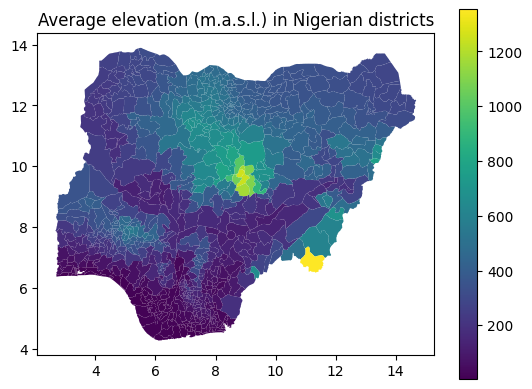

In [61]:
gdf.plot(column='mean_elev', legend=True )
plt.title("Average elevation (m.a.s.l.) in Nigerian districts")

In [62]:
gdf['location'] = gdf['adm2'] + ', ' + gdf['adm1']

## Coastal

In [63]:
coast = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/nigeria/nigeria_coast.shp')

In [64]:
coast['location'] = coast['adm2'] + ', ' + coast['adm1']

In [65]:
gdf['coast'] = [1 if x in coast['location'].unique() else 0 for x in gdf['location']]

In [ ]:
gdf.plot(column='coast', categorical= True, legend=True)

## Human Development Index

In [67]:
import pandas as pd

In [68]:
from unidecode import unidecode


In [69]:
hdi = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/demographic/nigeria/GDL-Subnational-HDI-data-5.csv')

In [70]:
hdi.rename(columns={'2021':'HDI'}, inplace=True)

In [71]:
hdi['Region'] = [x.replace('Nassarawa', 'Nasarawa') for x in hdi['Region']]
hdi['Region'] = [x.replace('Zamfora', 'Zamfara') for x in hdi['Region']]
hdi['Region'] = [x.replace('Abuja FCT', 'Federal Capital Territory') for x in hdi['Region']]




In [72]:
gdf = gdf.merge(hdi[['Region', 'HDI']], left_on='adm1', right_on='Region')

In [ ]:
gdf.plot()

In [ ]:
gdf.plot(column='HDI', legend=True)
plt.title('Provincial HDI France')

## Population density

In [75]:
#link: https://hub.worldpop.org/geodata/listing?id=77
values = "/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/demographic/nigeria/popdens/nga_pd_2020_1km_UNadj.tif"


stats = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["min", "max", "mean"]))
gdf = gdf.join(stats)


In [76]:
gdf.rename(columns={'mean':'popdens'}, inplace=True)

In [79]:
gdf = gdf[['adm1', 'adm2', 'geometry', 'mean_elev', 'location', 'coast', 'HDI', 'popdens']]

In [ ]:
gdf.plot(column='popdens')

## Age

In [81]:
import glob

In [ ]:
gdf['over60_pop'] = 0
for file in glob.glob('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/demographic/nigeria/age/*'):
    
    values = file
    
    pop_total = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["sum"]))
    gdf['over60_pop'] += pop_total['sum']




In [83]:
for file in glob.glob('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/demographic/nigeria/pop/*'):
    
    values = file
    
    over_60 = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["sum"]))
    gdf['pop_total'] = over_60['sum']

/Users/shivyucel/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [84]:
gdf['over60_propor'] = gdf['over60_pop'] / gdf['pop_total']

/Users/shivyucel/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Text(0.5, 1.0, 'Age 60+ population proportion')

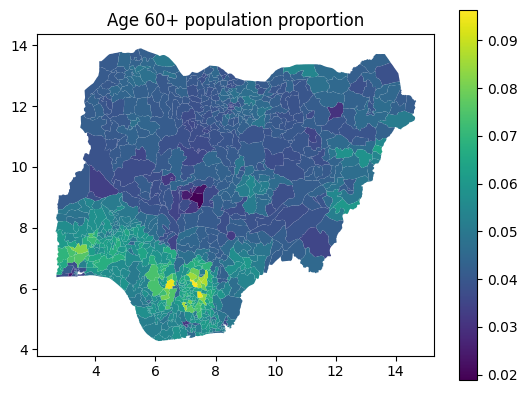

In [85]:
gdf.plot(column='over60_propor', legend=True)
plt.title("Age 60+ population proportion")

In [113]:
HDI_subset = gdf.drop_duplicates('HDI')

In [114]:
deciles = pd.qcut(HDI_subset['HDI'], 10, labels= range(1,11)).astype(int)

In [115]:
HDI_subset['HDI_dec'] = deciles

/Users/shivyucel/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [116]:
gdf = gdf.merge(HDI_subset[['HDI', 'HDI_dec']], on='HDI')

In [123]:
gdf['popden_dec'] = pd.qcut(gdf['popdens'], 10, labels= range(1,11)).astype(int)

In [124]:
gdf = gdf[gdf['over60_propor'].notnull()]

In [125]:
gdf['over60_dec'] = pd.qcut(gdf['over60_propor'], 10, labels= range(1,11)).astype(int)

In [127]:
gdf.to_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/nigeria/merged.shp')

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_64880/2005429883.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/nigeria/merged.shp')
